# Notebook for the making of Figure 3

In [1]:
import numpy as np
import pylab as plt
from numpy.fft import fftshift, ifftshift
import tensorflow as tf 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('/data/id01/inhouse/bellec/software/sharedipynb/Matteo/Predict_diffraction_phase/utilities/')
from predict_phase_2D_utilities import *
from custom_losses import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from functions import*
from interpolation_functions import*
from line_cross_standard_utilities import *
from line_cross_tensorflow_prediction_utilities import *

plt.rcParams['image.cmap'] = 'plasma'

2.2.0
Num GPUs Available:  1


2023-12-13 18:35:24.458368: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-12-13 18:35:24.578111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0035:03:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.50GiB deviceMemoryBandwidth: 836.37GiB/s
2023-12-13 18:35:24.585206: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-12-13 18:35:24.597920: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-12-13 18:35:24.605712: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-12-13 18:35:24.611675: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [2]:
# load the masked and ground truth data

path = '/data/projects/id01ml/Datasets/Phasing_Defect_free/3D_exp_128_all/dataset_BCDI_2021_05_06_011709_scan_8_0.6_1.npz'

data_linear = 1e5*np.load(path)['I']
mask = add_cross_gap3D(data_linear, gap_size = 6, gap_position = 90)
data_masked_linear  = data_linear*(1.-mask)

data_interp = np.log(data_linear+1)

In [3]:
nearest, linear, cubic = create_interpolated_data(data_interp,mask)

128 127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102 101 100 99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 

In [4]:
# I create this slice s to avoid having to write [:,:,64] all the time in the following
s = [slice(None) for n in range(3)]
s[2] = 64
s = tuple(s)

In [5]:
mask_vertical_pos = np.where(mask[s][:,0])[0]
print(mask_vertical_pos)
mask_vertical_pos = mask_vertical_pos[len(mask_vertical_pos)//2-1]
print(mask_vertical_pos)

[35 36 37 38 39 40]
37


In [6]:
data_masked, maxi_rescale1, maxi_rescale2 = data_preprocessing(data_masked_linear)
gap_params = find_gap_parameters(mask, verbose=True)

gap_shape : cross
axis_parallel : 2
gap_size : 6
mask_position : [37. 89. nan]
pixel_masked : [array([35, 36, 37, 38, 39, 40]) array([87, 88, 89, 90, 91, 92]) list([])]


In [7]:
from tensorflow.keras import losses

model_path = '/data/projects/id01ml/SavedModels/3D_inpainting_portions32_{}px_cross/'.format(gap_params['gap_size'])
print('model path :', model_path)
if os.path.exists(model_path):
    print('This gap size model exists')
    import tensorflow as tf 
    print(tf.__version__)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    model = tf.keras.models.load_model(model_path, custom_objects=None, compile=False)
    print('Models loading done.')
else:
    print('Error, this gap size model doesn\'t exits yet')

model path : /data/projects/id01ml/SavedModels/3D_inpainting_portions32_6px_cross/
This gap size model exists
2.2.0
Num GPUs Available:  1


2023-12-13 18:36:59.679477: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2023-12-13 18:36:59.680052: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x19c07050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-13 18:36:59.680073: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-13 18:36:59.816820: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x19f673d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 18:36:59.816861: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-12-13 18:36:59.817305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0035:03:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 d

Models loading done.


In [8]:
if gap_params['gap_size'] == 3 or gap_params['gap_size'] == 9:
    
    gap_params['mask_position'][1] = gap_params['mask_position'][1]-1
    gap_params['mask_position'][0] = gap_params['mask_position'][0]-1
    
gap_params['mask_position']

array([37., 89., nan])

In [48]:
# skip_pixels = 
skip_pixels = 0
prediction = gap_prediction(data_masked, mask, gap_params, model,
                   skip_pixels=skip_pixels)

2023-12-13 13:41:55.385007: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-12-13 13:42:01.278928: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 96 96 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

KeyboardInterrupt: 

In [ ]:
prediction_linear = post_processing_prediction(prediction,maxi_rescale1, maxi_rescale2)
# np.save('prediction_linear_fig3.npy', prediction_linear)

In [9]:
prediction_linear = np.load('prediction_linear_fig3.npy')

In [10]:
prediction_log = np.log(prediction_linear+1)
data_log = np.log(data_linear +1)

linear_lin = np.exp(linear)-1
nearest_lin = np.exp(nearest)-1
cubic_lin = np.exp(cubic) -1 

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar_subplot(fig,axes,imgs):
    i = 0
    for im, ax in zip(imgs,axes.flatten()):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = fig.colorbar(im, cax=cax, orientation='vertical')
        cb.ax.tick_params(labelsize = 20)
        if i == 0:
            cb.remove()
        i+=1
    fig.tight_layout()
    return


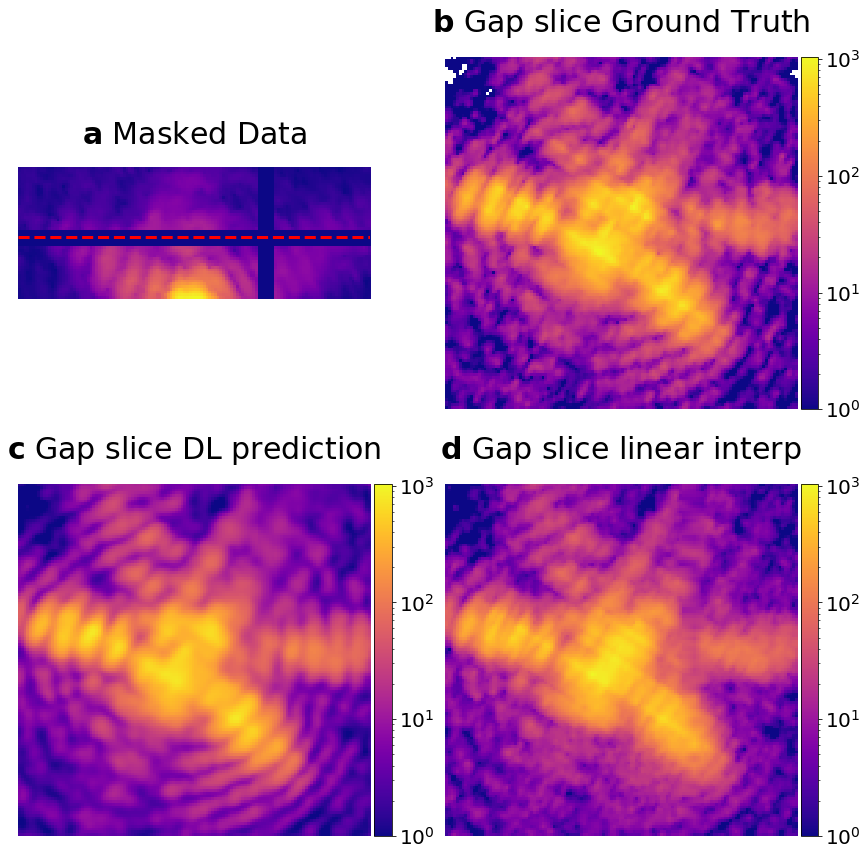

In [13]:
from matplotlib.colors import LogNorm

fw = 4
fig,ax = plt.subplots(2,2,figsize=(3*fw, 3*fw))
imgs = []

imgs.append(ax[0,0].matshow((data_log*(1.-mask))[12:60,:,64]))
ax[0,0].axhline(y=mask_vertical_pos-12, color='r', linestyle='--', linewidth=3)
ax[0,0].axis('off')

truth = np.copy(data_linear[mask_vertical_pos])
vmin = np.nanmin(truth)
vmax = np.nanmax(truth)

imgs.append(ax[0,1].matshow(np.rot90(10*truth,1), norm = LogNorm(vmin = 1, vmax = vmax*10 )))
ax[0,1].axis('off')
imgs.append(ax[1,0].matshow(np.rot90(10*prediction_linear[mask_vertical_pos],1), norm = LogNorm(vmin = 1, vmax = vmax*10)))
ax[1,0].axis('off')

imgs.append(ax[1,1].matshow(np.rot90(10*linear_lin[mask_vertical_pos],1), norm = LogNorm(vmin = 1, vmax = vmax*10)))
ax[1,1].axis('off')

# imgs.append(ax[2,0].matshow(np.rot90(nearest[mask_vertical_pos],1), vmin = vmin, vmax = vmax))
# ax[2,0].axis('off')

# imgs.append(ax[2,1].matshow(np.rot90(cubic[mask_vertical_pos],1),vmin = vmin, vmax = vmax))
# ax[2,1].axis('off')


ax[0,0].set_title('$\mathbf{a}$ Masked Data', fontsize=30)
ax[0,1].set_title('$\mathbf{b}$ Gap slice Ground Truth', fontsize=30)
ax[1, 0].set_title('$\mathbf{c}$ Gap slice DL prediction', fontsize=30)
ax[1,1].set_title('$\mathbf{d}$ Gap slice linear interp', fontsize=30)
# ax[2,0].set_title('e) gap slice n.n. interp \n accuracy = %.1f %%' %acc_nn, fontsize=30)
# ax[2,1].set_title('f) gap slice cubic interp \n accuracy = %.1f %%' %acc_cub, fontsize=30)


add_colorbar_subplot(fig,ax,imgs)

fig.tight_layout()
# plt.savefig('newfig3_nonumbers.pdf')

# For the figure in the Supplementary material

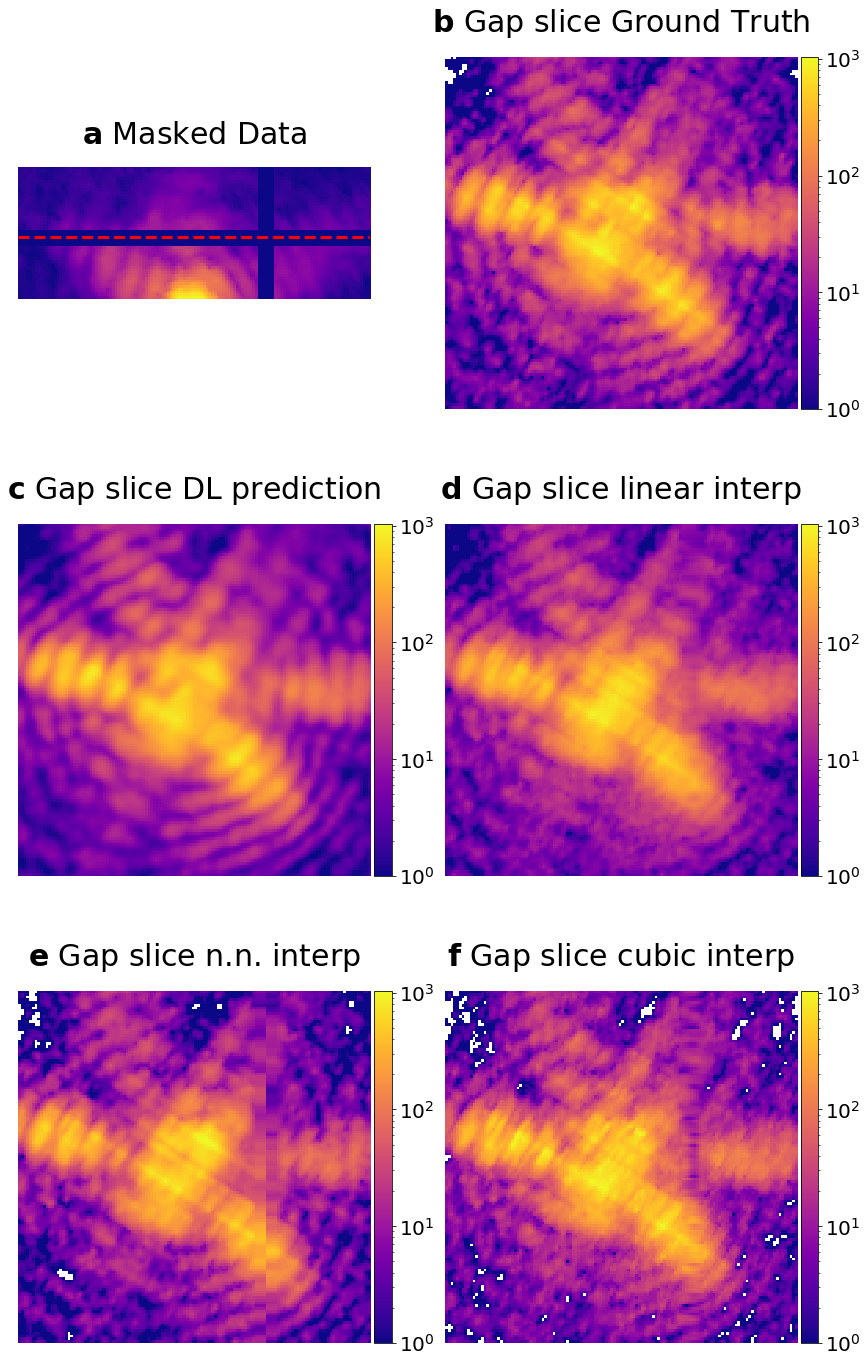

In [26]:
row = 3
col = 2
fig,ax = plt.subplots(row, col,figsize=(4*row, 10*col))
imgs = []

imgs.append(ax[0,0].matshow((data_log*(1.-mask))[12:60,:,64]))
ax[0,0].axhline(y=mask_vertical_pos-12, color='r', linestyle='--', linewidth=3)
ax[0,0].axis('off')

truth = np.copy(data_linear[mask_vertical_pos])
vmin = np.nanmin(truth)
vmax = np.nanmax(truth)

imgs.append(ax[0,1].matshow(np.rot90(10*truth,1), norm = LogNorm(vmin = 1, vmax = vmax*10 )))
ax[0,1].axis('off')
imgs.append(ax[1,0].matshow(np.rot90(10*prediction_linear[mask_vertical_pos],1), norm = LogNorm(vmin = 1, vmax = vmax*10)))
ax[1,0].axis('off')

imgs.append(ax[1,1].matshow(np.rot90(10*linear_lin[mask_vertical_pos],1), norm = LogNorm(vmin = 1, vmax = vmax*10)))
ax[1,1].axis('off')

imgs.append(ax[2,0].matshow(np.rot90(10*nearest_lin[mask_vertical_pos],1), norm = LogNorm(vmin = 1, vmax = vmax*10)))
ax[2,0].axis('off')

imgs.append(ax[2,1].matshow(np.rot90(10*cubic_lin[mask_vertical_pos],1), norm = LogNorm(vmin = 1, vmax = vmax*10)))
ax[2,1].axis('off')


ax[0,0].set_title('$\mathbf{a}$ Masked Data', fontsize=30)
ax[0,1].set_title('$\mathbf{b}$ Gap slice Ground Truth', fontsize=30)
ax[1, 0].set_title('$\mathbf{c}$ Gap slice DL prediction', fontsize=30)
ax[1,1].set_title('$\mathbf{d}$ Gap slice linear interp', fontsize=30)
ax[2,0].set_title('$\mathbf{e}$ Gap slice n.n. interp' , fontsize=30)
ax[2,1].set_title('$\mathbf{f}$ Gap slice cubic interp' , fontsize=30)


add_colorbar_subplot(fig,ax,imgs)

fig.tight_layout()
plt.savefig('newfig3_suppl.pdf')